In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import helper_400

%load_ext autoreload
%autoreload 2
helper_400.set_sns_style()

<Figure size 800x600 with 0 Axes>

In [3]:
%load_ext lab_black

In [4]:
cols = [
    "STCNTY",
    "FIPS",
    "E_TOTPOP",
    "E_AFAM",
    "E_HISP",
    "E_ASIAN",
    "E_AIAN",
    "E_NHPI",
    "E_TWOMORE",
    "E_OTHERRACE",
]

In [5]:
df = helper_400.get_svi_df(cols)

In [6]:
df["E_WHITE"] = df["E_TOTPOP"] - df[
    ["E_AFAM", "E_HISP", "E_ASIAN", "E_AIAN", "E_NHPI", "E_TWOMORE", "E_OTHERRACE"]
].sum(axis=1)

In [7]:
df.head()

,STCNTY,FIPS,E_TOTPOP,E_AFAM,E_HISP,E_ASIAN,E_AIAN,E_NHPI,E_TWOMORE,E_OTHERRACE,E_WHITE
0,6001,6001400100,3035,94,125,424,0,0,170,17,2205
1,6001,6001400200,1983,44,163,219,6,0,211,7,1333
2,6001,6001400300,5058,433,463,773,6,34,209,55,3085
3,6001,6001400400,4179,278,473,418,27,0,282,6,2695
4,6001,6001400500,4021,1101,359,387,0,0,377,0,1797


# Exposure per FIPS over time

In [8]:
exposure = helper_400.get_exposure_df()

In [9]:
df = df.merge(exposure, left_on="FIPS", right_on="GEOID")

In [10]:
df.head()

,STCNTY,FIPS,E_TOTPOP,E_AFAM,E_HISP,E_ASIAN,E_AIAN,E_NHPI,E_TWOMORE,E_OTHERRACE,...,heatday,smoke_pm_non_zero,smoke_pm_gt_five,hw,hs,hws,ws,hs5,hws5,ws5
0,6001,6001400100,3035,94,125,424,0,0,170,17,...,289,433,134,0,61,0,0,25,0,0
1,6001,6001400200,1983,44,163,219,6,0,211,7,...,300,410,136,0,50,0,0,20,0,0
2,6001,6001400300,5058,433,463,773,6,34,209,55,...,300,410,136,0,50,0,0,20,0,0
3,6001,6001400400,4179,278,473,418,27,0,282,6,...,300,410,136,0,50,0,0,20,0,0
4,6001,6001400500,4021,1101,359,387,0,0,377,0,...,300,410,136,0,50,0,0,20,0,0


In [11]:
hotspots = helper_400.hotspots

In [12]:
demographic_cols = [
    "E_AFAM",
    "E_HISP",
    "E_ASIAN",
    "E_AIAN",
    "E_NHPI",
    "E_TWOMORE",
    "E_OTHERRACE",
    "E_WHITE",
    "E_TOTPOP",
]

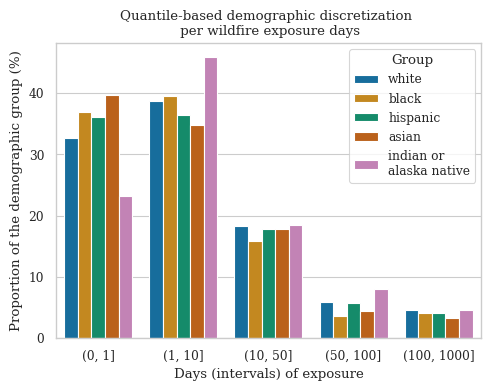

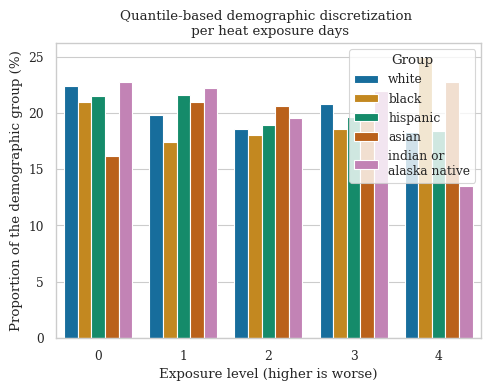

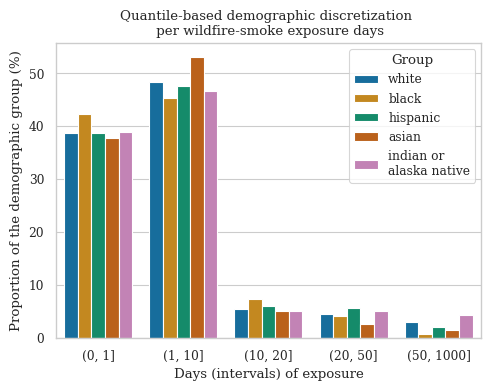

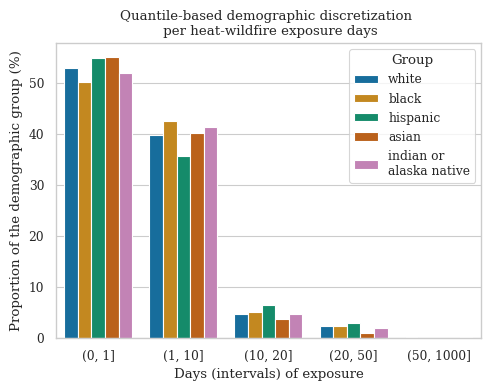

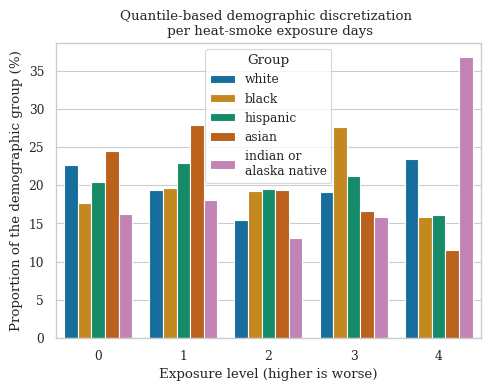

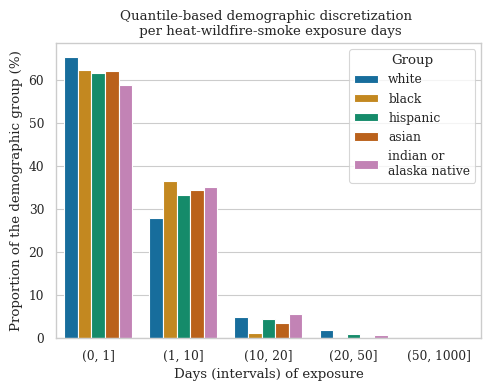

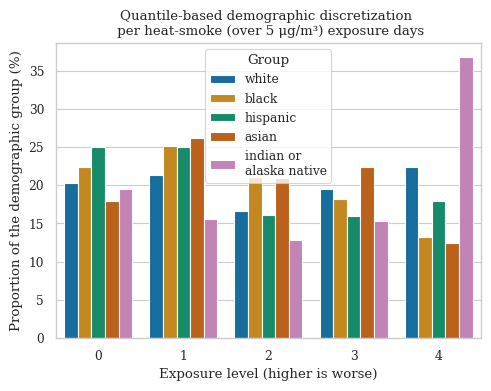

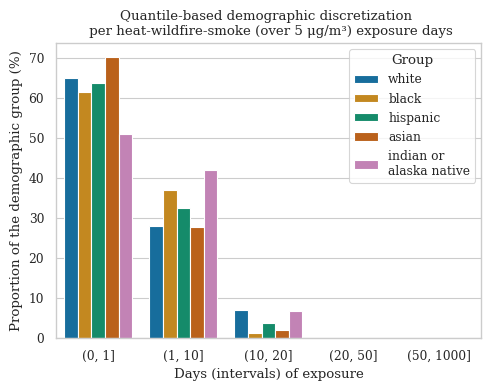

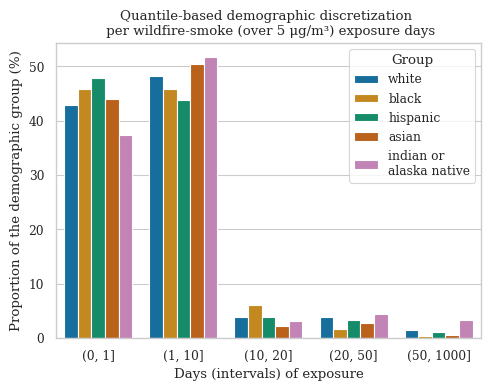

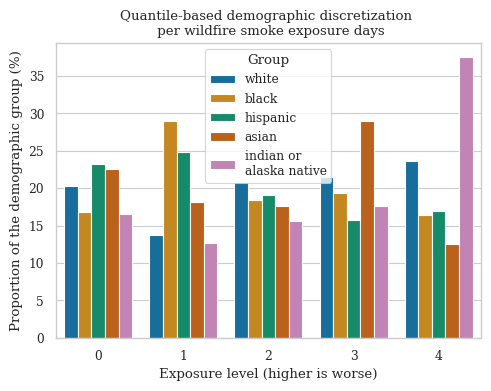

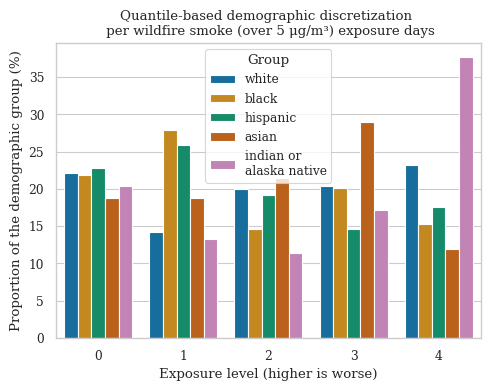

In [13]:
for hspt in hotspots.keys():
    df["exposure_category"] = helper_400.get_cut_vars(hspt, df[hspt])

    exposure_per_category = df.groupby("exposure_category")[demographic_cols].sum()

    for dc in demographic_cols:
        exposure_per_category[dc + "_normalized"] = (
            exposure_per_category[dc] * 100 / exposure_per_category[dc].sum()
        )

    exposure_per_category = exposure_per_category.drop(columns=demographic_cols)

    exposure_per_category = exposure_per_category.drop(
        columns=[
            "E_TOTPOP_normalized",
            "E_NHPI_normalized",
            "E_TWOMORE_normalized",
            "E_OTHERRACE_normalized",
        ]
    )

    exposure_per_category = exposure_per_category[
        [
            "E_WHITE_normalized",
            "E_AFAM_normalized",
            "E_HISP_normalized",
            "E_ASIAN_normalized",
            "E_AIAN_normalized",
        ]
    ]

    exposure_per_category = exposure_per_category.rename(
        columns={
            "E_WHITE_normalized": "white",
            "E_AFAM_normalized": "black",
            "E_HISP_normalized": "hispanic",
            "E_ASIAN_normalized": "asian",
            "E_AIAN_normalized": "indian or \nalaska native",
        }
    )

    helper_400.plot_qbar(exposure_per_category, hspt, figname="race", legloc="best")